In [1]:
# read the text data
from datasets import load_from_disk
ds = load_from_disk('/Users/kailiu/LLMProject/data/imdb_dataset')
ds['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pandas as pd
stop_words = list(stopwords.words('english'))






In [3]:
# make a function to process the data
def process_data(ds, stop_words, data_type, vectorizer=None):
    # If no vectorizer is provided, create and fit one on the training data
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words=stop_words)
        data = vectorizer.fit_transform(ds[data_type]['text'])
    else:
        # Use the provided vectorizer to transform the data
        data = vectorizer.transform(ds[data_type]['text'])
    
    df = pd.DataFrame(data.toarray(),
                      columns=vectorizer.get_feature_names_out(),
                      index=ds[data_type]['text'])
    df = df.reset_index(drop=True)
    return df, vectorizer

In [4]:
# Process training data and get the fitted vectorizer
x_train, vectorizer = process_data(ds, stop_words, 'train')

# Process test data using the same vectorizer
x_test, _ = process_data(ds, stop_words, 'test', vectorizer=vectorizer)

In [5]:
y_train = ds['train']['label']
y_test = ds['test']['label']

In [6]:
# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

# test
clf.score(x_train, y_train)

1.0

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# performance on test set
rf_test_accuracy = accuracy_score(y_test, clf.predict(x_test))
rf_test_precision = precision_score(y_test, clf.predict(x_test))
rf_test_recall = recall_score(y_test, clf.predict(x_test))
rf_test_f1_score = f1_score(y_test, clf.predict(x_test))
rf_test_confusion_matrix = confusion_matrix(y_test, clf.predict(x_test))

print(f'Test Accuracy: {rf_test_accuracy:.4f}')
print(f'Test Precision: {rf_test_precision:.4f}')
print(f'Test Recall: {rf_test_recall:.4f}')
print(f'Test F1 Score: {rf_test_f1_score:.4f}')
print('Test Confusion Matrix:')
print(rf_test_confusion_matrix)


Test Accuracy: 0.8512
Test Precision: 0.8613
Test Recall: 0.8372
Test F1 Score: 0.8491
Test Confusion Matrix:
[[10815  1685]
 [ 2035 10465]]


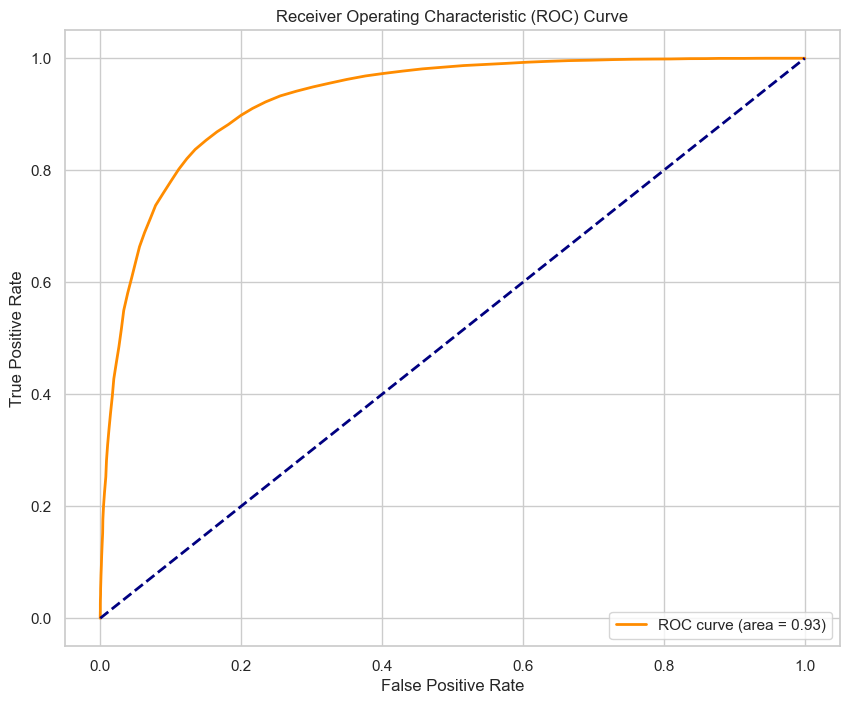

In [8]:
#draw roc and auc
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

#plot roc curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# check the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [10]:
# Convert DataFrame to tensor and move to device
X_tensor = torch.tensor(x_train.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define model and move to device
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        return x

input_dim = x_train.shape[1]
model = BinaryClassifier(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/10], Loss: 0.6899
Epoch [2/10], Loss: 0.6894
Epoch [3/10], Loss: 0.6801
Epoch [4/10], Loss: 0.6886
Epoch [5/10], Loss: 0.6772
Epoch [6/10], Loss: 0.6787
Epoch [7/10], Loss: 0.6827
Epoch [8/10], Loss: 0.6820
Epoch [9/10], Loss: 0.6691
Epoch [10/10], Loss: 0.6846


In [11]:
# Test the model on the test dataset
# Convert test DataFrame to tensor and move to device
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(ds['test']['label'], dtype=torch.float32).to(device)
with torch.no_grad():
    # Get predictions on the test set
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs.squeeze() > 0.5).cpu().numpy()  # Convert probabilities to binary predictions

    # Convert true test labels to numpy array
    true_test_labels = y_test_tensor.cpu().numpy()

    # Calculate evaluation metrics for the test set
    test_accuracy = accuracy_score(true_test_labels, test_predictions)
    test_precision = precision_score(true_test_labels, test_predictions)
    test_recall = recall_score(true_test_labels, test_predictions)
    test_f1 = f1_score(true_test_labels, test_predictions)
    test_conf_matrix = confusion_matrix(true_test_labels, test_predictions)

    # Print evaluation metrics for the test set
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print('Test Confusion Matrix:')
    print(test_conf_matrix)



Test Accuracy: 0.7906
Test Precision: 0.7689
Test Recall: 0.8309
Test F1 Score: 0.7987
Test Confusion Matrix:
[[ 9379  3121]
 [ 2114 10386]]


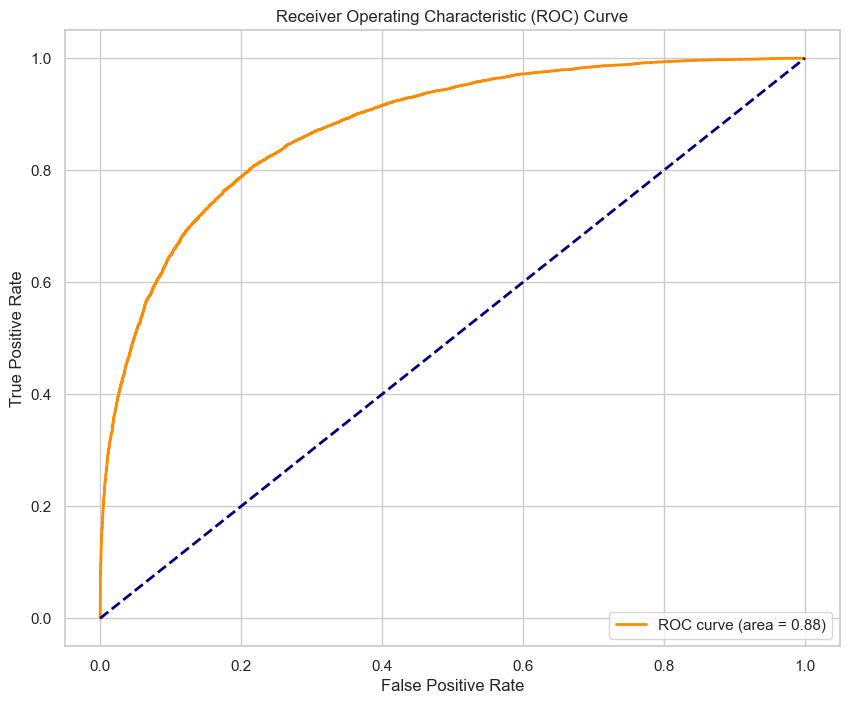

In [13]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_test_labels, test_outputs.squeeze().cpu().numpy())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()  